## Convolutional Dictionary Learning Tutorial 

The code used in this scriprt is modified from https://github.com/tbardouille/camcan_CSC_beta

This method takes in preprocessed MEG data in .fif file format. For each pattern detected by the algorithm, 3 components are returned representing the spatial pattern, temporal pattern, and activation timing throughout the recording.

Note that this tutorial relies on utility scripts utils_csc.py and utils_plot.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [16]:
# Imports 
import seaborn as sns
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from codecs import ignore_errors
import scipy.signal as ss
from sklearn import cluster
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
from pathlib import Path
import pickle
from joblib import Memory, Parallel, delayed
from scipy import stats
from scipy import signal
import mne
import scipy.io as io

from alphacsc import BatchCDL, GreedyCDL
from alphacsc.utils.signal import split_signal
from alphacsc.utils.convolution import construct_X_multi

In [17]:
# Fucntion to run CDL on given dataset given globally-defined model parameters
def run_csc(X, **cdl_params):
    """Run a CSC model on a given signal X.

    Parameters
    ----------
    X : numpy.ndarray
        the data to run the CSC on

    cdl_params : dict
        dictionary of CSC parameters, such as 'n_atoms', 'n_times_atoms', etc.

    Returns
    -------
    cdl_model

    z_hat_

    """
    print('Computing CSC')

    cdl_params = dict(cdl_params)
    n_splits = cdl_params.pop('n_splits', 1)
    use_batch_cdl = cdl_params.pop('use_batch_cdl', False)
    if use_batch_cdl:
        cdl_model = BatchCDL(**cdl_params)
    else:
        cdl_model = GreedyCDL(**cdl_params)

    if n_splits > 1:
        X_splits = split_signal(X, n_splits=n_splits, apply_window=True)
        X = X[None, :]
    else:
        X_splits = X.copy()

    # Fit the model and learn rank1 atoms
    print('Running CSC')
    cdl_model.fit(X_splits)

    z_hat_ = cdl_model.transform(X)
    return cdl_model, z_hat_

In [51]:
# Read in 2-dimensional time series data as a .fif file (already preprocessed)
data_dir = '/export03/data/lindseyp/burst_methods_review/2d_data_raw.fif'
raw = mne.io.read_raw_fif(data_dir, preload=True)
print(raw)

Opening raw data file /export03/data/lindseyp/burst_methods_review/2d_data_raw.fif...
Isotrak not found
    Range : 10000 ... 457000 =     10.000 ...   457.000 secs
Ready.
Reading 0 ... 447000  =      0.000 ...   447.000 secs...
<Raw | 2d_data_raw.fif, 333 x 447001 (447.0 s), ~1.11 GB, data loaded>


### 1. Set Model Parameters 

The CDL model requires the user to define a pattern duration ("atom_duration") and a number of patterns to detect ("n_atoms"). The pattern duration is particularly important for identifying bursts and should be set to a window length about 2x the approximate burst duration of interest. Adjusting the number of patterns allows you to view a larger variety of more or less frequently occuring patterns. 

More information about adjusting other parameters can be found at https://alphacsc.github.io/stable/index.html

In [52]:
# Set some global variables #
EXP_PARAMS = {
    "sfreq": 1000.,             
    "atom_duration": 0.5,   # pattern duration in seconds    
    "n_atoms":3,         # number of patterns to detect     
    "reg": 0.2,                
    "eps": 1e-5,               
    "tol_z": 1e-3,             
}

CDL_PARAMS = {
    'n_atoms': EXP_PARAMS['n_atoms'],
    'n_times_atom': int(np.round(EXP_PARAMS["atom_duration"] * EXP_PARAMS['sfreq'])),
    'rank1': True, 'uv_constraint': 'separate',
    'window': True,
    'unbiased_z_hat': True,
    'D_init': 'chunk',
    'lmbd_max': 'scaled',
    'reg': EXP_PARAMS['reg'],
    'n_iter': 100,
    'eps': EXP_PARAMS['eps'],
    'solver_z': 'lgcd',
    'solver_z_kwargs': {'tol': EXP_PARAMS['tol_z'],
                        'max_iter': 1000},
    'solver_d': 'alternate_adaptive',
    'solver_d_kwargs': {'max_iter': 300},
    'sort_atoms': True,
    'verbose': 1,
    'random_state': 0,
    'use_batch_cdl': True,
    'n_splits': 20,
    'n_jobs': 5
}

### 2. Apply CDL 

CDL relies on utility scripts and integrated python packages (alphacsc; Jas et al., 2017; Dupre la Tour et al., 2018). Therefore, local processing of the data is not required and a simple function call will execute the necessary steps to fit the CDL model to the data. 

Calling 'run_csc' generates a cdl_model object containing a spatial pattern (u_hat), a temporal pattern (v_hat), and an activation vector (z_hat; length of overall recording). Burst shapes and spatial weights can be inferred fromt the v and u vectors, respectively. Burst timing and power can be inferred from the z vector. 

More information on the specific processing steps of the model can be found in utils_csc.py available at https://github.com/lindseypower/BurstDetection_Tutorials

In [53]:
# Run CDL model on MEG channels in dataset
dat = raw.get_data(picks=['meg'])
cdl_model, z_hat_ = run_csc(dat,**CDL_PARAMS)

Computing CSC
Running CSC
....................................
[BatchCDL] Converged after 36 iteration, (dz, du) = 8.232e-06, 1.273e-06
[BatchCDL] Fit in 1100.4s
Refitting the activation to avoid amplitude bias...done


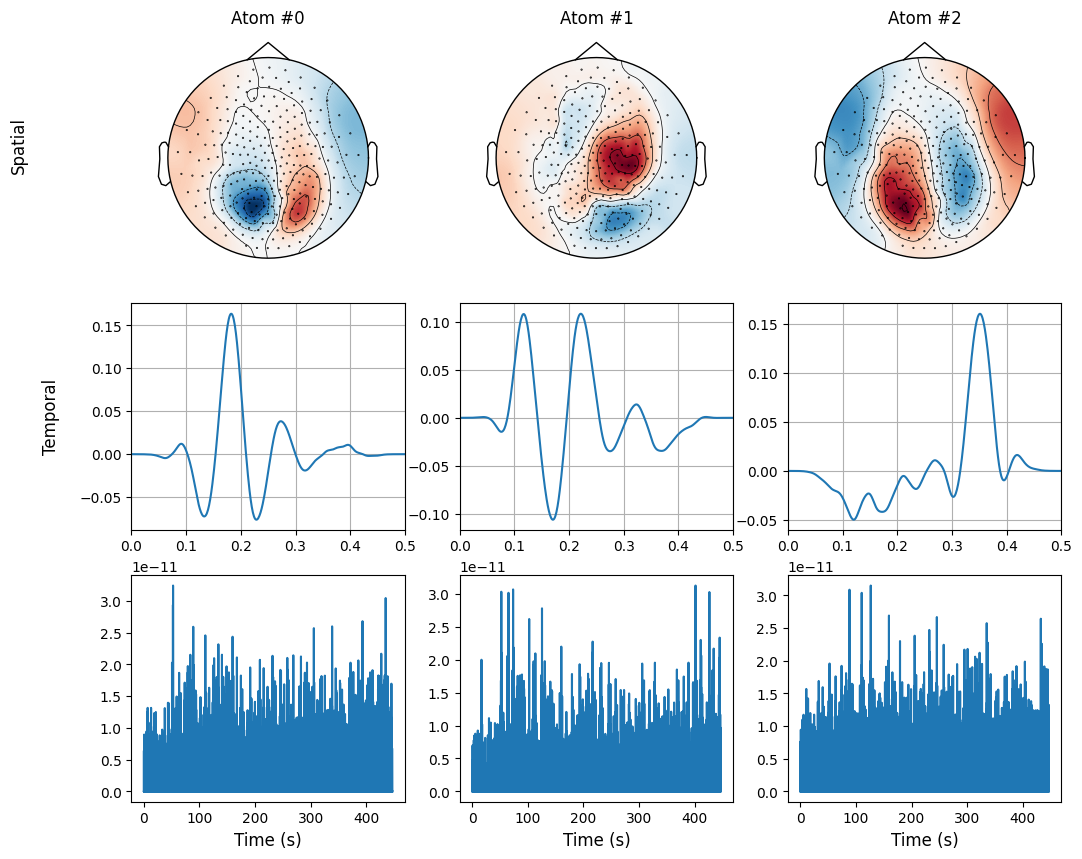

In [54]:
## Plotting ##

# Read in a layout file for plotting the sensor topography 
# This may not be necessary depending on how the data was preprocessed - required here because the data was preprocessed in brainstorm 
pos_file = '/export03/data/lindseyp/burst_methods_review/ctf270.mat'
ctf270 = io.loadmat(pos_file)

# Set plotting parameters 
Fs = 1000
fontsize = 12
n_atoms_per_fig = 3
n_plot_per_atom = 3
n_atoms_est = z_hat_.shape[1]
info = raw.info
atom_duration = cdl_model.v_hat_.shape[-1] / Fs
figsize = (12, 10)

atoms_in_figs = np.arange(0, n_atoms_est + 1, n_atoms_per_fig)
atoms_in_figs = list(zip(atoms_in_figs[:-1], atoms_in_figs[1:]))

# Loop through each pattern detected by CDL and create a plot with the u, v, and z vectors displayed for each 
burst_proxim_df = []
figs = []
for fig_idx, (atoms_start, atoms_stop) in enumerate(atoms_in_figs, start=1):
    fig, axes = plt.subplots(
        n_plot_per_atom, n_atoms_per_fig, figsize=figsize)
    figs.append(fig)
    fig.suptitle(None, fontsize=fontsize)
    for i_atom, kk in enumerate(range(atoms_start, atoms_stop)):
        ax = axes[0, i_atom]
        ax.set_title("Atom #" + str(kk), fontsize=fontsize)

        # Spatial pattern
        u_hat = cdl_model.u_hat_[kk]
        mne.viz.plot_topomap(u_hat,  pos = ctf270['pos'], sphere=0.5,axes=ax, show=False)
        if i_atom == 0:
            ax.set_ylabel("Spatial", labelpad=86, fontsize=fontsize)

        # Temporal pattern
        ax = axes[1, i_atom]
        v_hat = cdl_model.v_hat_[kk]
        t = np.arange(v_hat.size) / Fs
        ax.plot(t, v_hat)
        ax.grid(True)
        ax.set_xlim(0, atom_duration)  # crop x axis
        if i_atom == 0:
            ax.set_ylabel("Temporal", labelpad=14, fontsize=fontsize)

        # Atom's activations
        padding = np.zeros(int(atom_duration*Fs-1))
        z_hat = z_hat_[0,kk,:]
        z_hat = np.concatenate([z_hat, padding])
        ax = axes[2, i_atom]
        t1 = np.arange(0,dat.shape[1])/ Fs
        ax.plot(t1, z_hat)
        ax.set_xlabel("Time (s)", fontsize=fontsize)
plt.show()

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


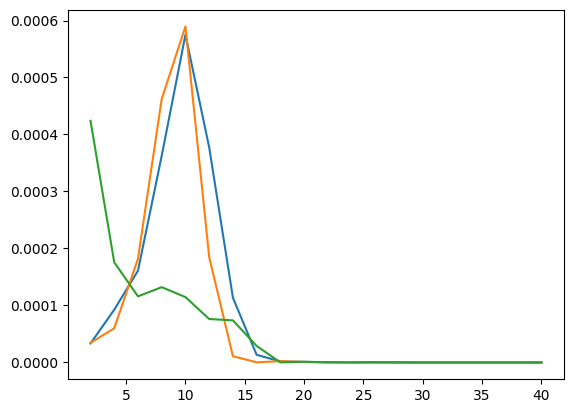

In [55]:
# Plot PSD to show the frequency composition of each detected pattern
v_hat = cdl_model.v_hat_
v_hat.shape

PSD0, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[0,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD1, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[1,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD2, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[2,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)

plt.plot(PSD_fVec, PSD0)
plt.plot(PSD_fVec, PSD1)
plt.plot(PSD_fVec, PSD2)

Most of these atoms resemble occipital alpha type patterns because alpha tends to be the dominant frequency in the signal. If we are interested in a different frequency (e.g., beta bursts) we may wish to apply a tighter bandpass to the signal to target the frequency range of interest.

In [26]:
# Filter the data to 15-30 Hz frequency range and then run CDL model again
raw.filter(15,30)
dat = raw.get_data(picks=['meg'])
cdl_model, z_hat_ = run_csc(dat,**CDL_PARAMS)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 15 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 15.00
- Lower transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 13.12 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 881 samples (0.881 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    6.6s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:   11.8s
[Parallel(n_jobs=1)]: Done 287 tasks      | elapsed:   16.4s


Computing CSC
Running CSC
...................
[BatchCDL] Converged after 19 iteration, (dz, du) = 9.721e-06, 8.135e-06
[BatchCDL] Fit in 526.5s
Refitting the activation to avoid amplitude bias...done


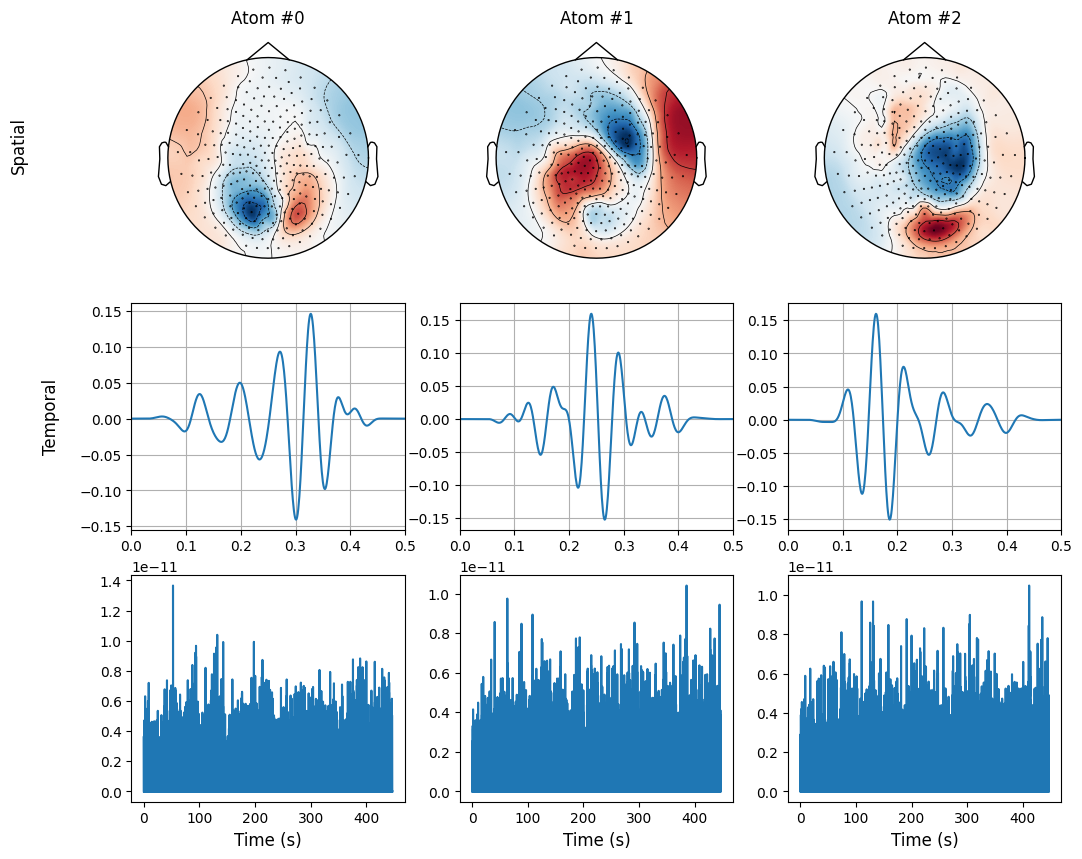

In [27]:
### Plotting ###

atoms_in_figs = np.arange(0, n_atoms_est + 1, n_atoms_per_fig)
atoms_in_figs = list(zip(atoms_in_figs[:-1], atoms_in_figs[1:]))

# Loop through each pattern detected by CDL and create a plot with the u, v, and z vectors displayed for each 
burst_proxim_df = []
figs = []
for fig_idx, (atoms_start, atoms_stop) in enumerate(atoms_in_figs, start=1):
    fig, axes = plt.subplots(
        n_plot_per_atom, n_atoms_per_fig, figsize=figsize)
    figs.append(fig)
    fig.suptitle(None, fontsize=fontsize)
    for i_atom, kk in enumerate(range(atoms_start, atoms_stop)):
        ax = axes[0, i_atom]
        ax.set_title("Atom #" + str(kk), fontsize=fontsize)

                # Spatial pattern
        u_hat = cdl_model.u_hat_[kk]
        mne.viz.plot_topomap(u_hat,  pos = ctf270['pos'], sphere=0.5,axes=ax, show=False)
        if i_atom == 0:
            ax.set_ylabel("Spatial", labelpad=86, fontsize=fontsize)

        # Temporal pattern
        ax = axes[1, i_atom]
        v_hat = cdl_model.v_hat_[kk]
        t = np.arange(v_hat.size) / Fs
        ax.plot(t, v_hat)
        ax.grid(True)
        ax.set_xlim(0, atom_duration)  # crop x axis
        if i_atom == 0:
            ax.set_ylabel("Temporal", labelpad=14, fontsize=fontsize)

        # Atom's activations
        padding = np.zeros(int(atom_duration*Fs-1))
        z_hat = z_hat_[0,kk,:]
        z_hat = np.concatenate([z_hat, padding])
        ax = axes[2, i_atom]
        t1 = np.arange(0,dat.shape[1])/ Fs
        ax.plot(t1, z_hat)
        ax.set_xlabel("Time (s)", fontsize=fontsize)

Effective window size : 0.500 (s)
Effective window size : 0.500 (s)
Effective window size : 0.500 (s)


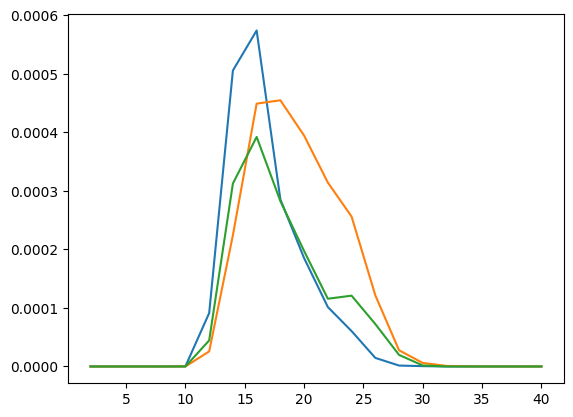

In [50]:
# Plot PSDs for each 
v_hat = cdl_model.v_hat_

PSD0, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[0,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD1, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[1,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)
PSD2, PSD_fVec = mne.time_frequency.psd_array_welch(v_hat[2,:], Fs, fmin=1, fmax=40, n_fft=500, n_overlap=400)

plt.plot(PSD_fVec, PSD0)
plt.plot(PSD_fVec, PSD1)
plt.plot(PSD_fVec, PSD2)

Now we can see that the patterns have waveforms resembling beta bursts. You can adjust the model parameters (e.g., number of patterns, length of pattern) to explore different types of model outputs. 